## Classwork 2 - Regression Modeling in R

### Exercise 1

The following dataset contains observational measurements related to the impact of three advertising medias on sales of a product, $P$. The variables are:

- `youtube`: the advertising budget allocated to YouTube. Measured in thousands of dollars;

- `facebook`: the advertising budget allocated to Facebook. Measured in thousands of dollars; and

- `newspaper`: the advertising budget allocated to a local newspaper. Measured in thousands of dollars.

- `sales`: the value in the $i^{th}$ row of the sales column is a measurement of the sales (in thousands of units) for product $P$ for company $i$.

The advertising data treat "a company selling product $P$" as the statistical unit, and "all companies selling product $P$" as the population. We assume that the $n = 200$ companies in the dataset were chosen at random from the population (a strong assumption!).

In [1]:
library(ggplot2)

marketing = read.csv('marketing_data.csv')
head(marketing, 15)

,youtube,facebook,newspaper,sales
,<dbl>,<dbl>,<dbl>,<dbl>
1,276.12,45.36,83.04,26.52
2,53.40,47.16,54.12,12.48
3,20.64,55.08,83.16,11.16
4,181.80,49.56,70.20,22.20
5,216.96,12.96,70.08,15.48
6,10.44,58.68,90.00,8.64
7,69.00,39.36,28.20,14.16
8,144.24,23.52,13.92,15.84
9,10.32,2.52,1.20,5.76


**Exploratory data analysis**

Before we model the data, let's first explore the data. We'll first check to see whether there are any missing values in the dataset. Then, we'll take a look at some univariate and bivariate summaries of the data.

*Note that, in an earlier lesson, we discussed the importance of randomly partitioning the data, and using one subset of the data for exploratory data analysis, another for fitting the model, and then possibly a third for model validation. However, for this dataset, there are only $n = 200$ units in the sample, and so there is not enough data for three robust subsets. So, we'll proceed to perform EDA on the entire dataset, but noting that our conclusions may be less certain because of the possibility of error due to "double dipping".*

**Missing data and univariate explorations**

Are there any missing values coded as `NA`? Or, are there any odd values for variables, e.g., `9999` or `0` possibly standing in for a missing value?

In [8]:
# (1) Code Here
dim(marketing)
summary(marketing)
sum(is.na(marketing))
marketing$facebook[order(marketing$facebook)[1:5]]

[1] 200   4

    youtube          facebook       newspaper          sales      
 Min.   :  0.84   Min.   : 0.00   Min.   :  0.36   Min.   : 1.92  
 1st Qu.: 89.25   1st Qu.:11.97   1st Qu.: 15.30   1st Qu.:12.45  
 Median :179.70   Median :27.48   Median : 30.90   Median :15.48  
 Mean   :176.45   Mean   :27.92   Mean   : 36.66   Mean   :16.83  
 3rd Qu.:262.59   3rd Qu.:43.83   3rd Qu.: 54.12   3rd Qu.:20.88  
 Max.   :355.68   Max.   :59.52   Max.   :136.80   Max.   :32.40  

[1] 0

[1] 0.00 0.36 0.48 0.96 1.56

There are no values coded as `NA`. `facebook` does have `0` as a value, but it's not clear that this is a missing value. It's plausible that some company simply does not have a Facebook marketing budget. There don't appear to be any values like `9999` indicating missing values. So, we'll proceed under the assumption that we have all the data!

Construct a histogram of each of the variables and comment on their distributions.

Warning message in geom_histogram(bins = 12, colo = "black", fill = "#CFB87C", alpha = 0.8):
“Ignoring unknown parameters: `colo`”


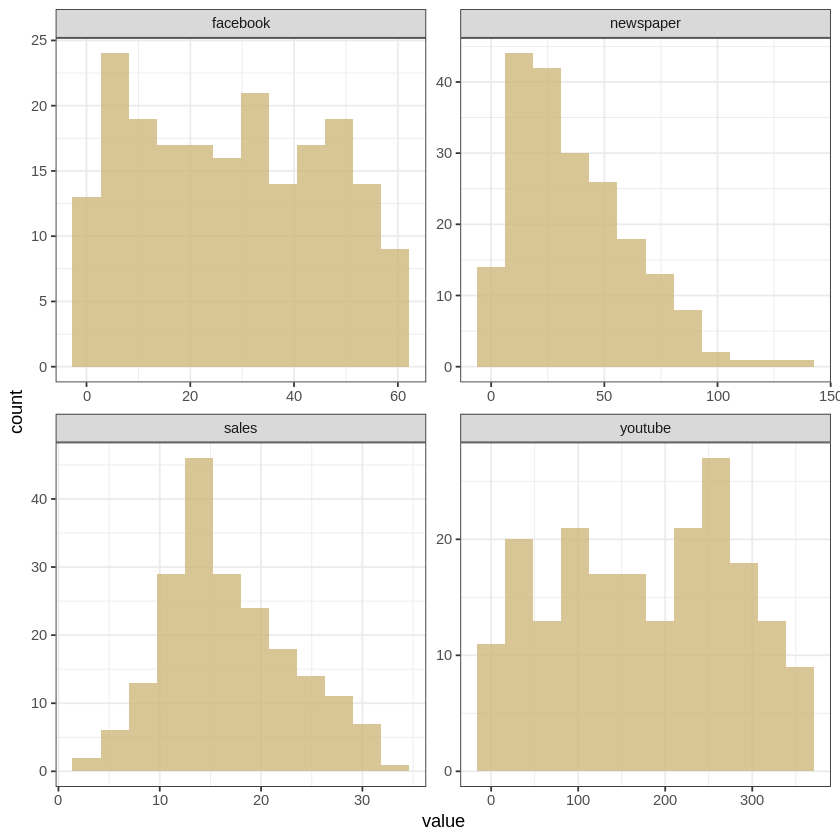

In [10]:
library(purrr)
library(tidyr)
library(ggplot2)

# (2) Code Here
marketing %>%
  keep(is.numeric) %>%
  gather() %>%
  ggplot(aes(value)) +
    facet_wrap(~key, scales = "free") +
      geom_histogram(bins=12,colo='black',fill='#CFB87C',alpha=0.8)+
      theme_bw()


The histograms of each variable provide insight into the distributions of the variables. None look normal; however, there is no requirement that the predictors (`facebook`, `youtube`, `newspaper`) come from a normal distribution. The response, `sales` does not look all that normal, but as we'll see, some regression analyses can be fairly robust to deviations in the normality assumption.

As you may have noticed from the histogram of `newspaper`, there may be a few outliers. Let's look at some boxplots to see in further detail. Note that R classifies potential outliers by the "IQR criterion". This criterion means that all observations above $q_{0.75}+1.5\times IQR$ or below $q_{0.25}-1.5\times IQR$ are classified as outliers, where

- $q_{0.25}$ is the first quartile;
- $q_{0.75}$ is the third quartile.
- IQR is the interquartile range, defined as the difference between the third and first quartile.

A boxplot will "flag" the outliers. Construct a boxplot for each variable and comment on the existence of potential outliers.

[1] 121.08

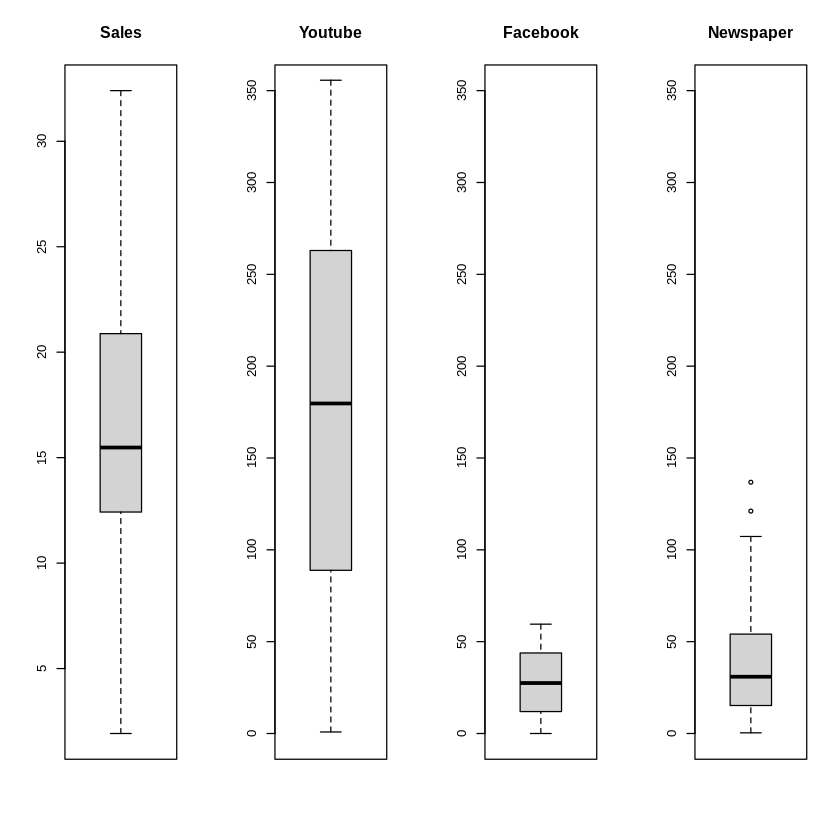

In [20]:
# (3) Code Here
par(mfrow = c(1,4))
boxplot(marketing$sales, main = "Sales")
boxplot(marketing$youtube, main = "Youtube", ylim = c(0,350))
boxplot(marketing$facebook, main = "Facebook", ylim = c(0,350))
boxplot(marketing$newspaper, main = "Newspaper", ylim = c(0,350))


boxplot.stats(marketing$newspaper)$out[2]

**Bivariate explorations**

Let's now explore how the variables may or may not relate to each other. First, calculate the correlations between variables. Correlations can help us meaasure the strength of the linear relationship between variables. The bland way to do this is with to `cor()` function. But try the `corrplot()` function in the `corrplot` library (which you'll need to install in your R environment in Anaconda). Comment on the correlations.

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



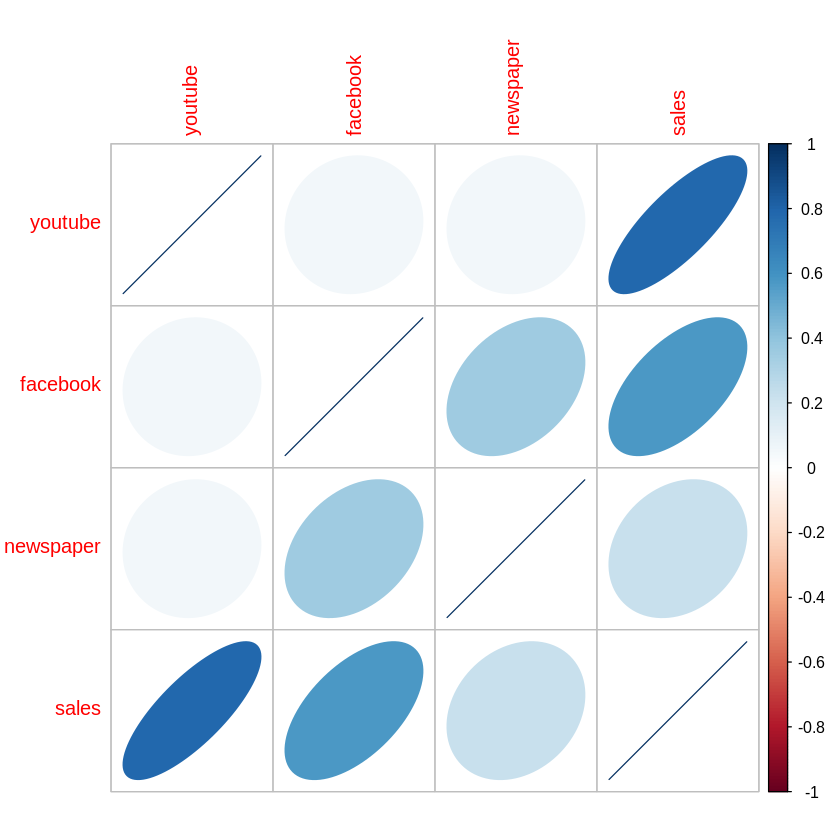

In [22]:
install.packages("corrplot")
library(corrplot)

# (4) Code Here
corrplot(cor(marketing),method = 'ellipse')

Note that there's a relatively strong correlation between `sales` and `youtube`, and `sales` and `facebook`.

However, knowing correlations alone isn't enough; the correlation coefficient can be misleading if there are nonlinear relationships, and so we should explore the relationships further.

To do so, we'll look at pairwise scatter plots, i.e., a scatter plot of each variable with each other variable. We should be looking for:

- Relationships between the response and each predictor.
- Relationships between predictor variables. Such relationships are undesirable.

Create all possible pairwise scatter plots of the data (the `pairs()` function may help). Comment on the observed relationships.

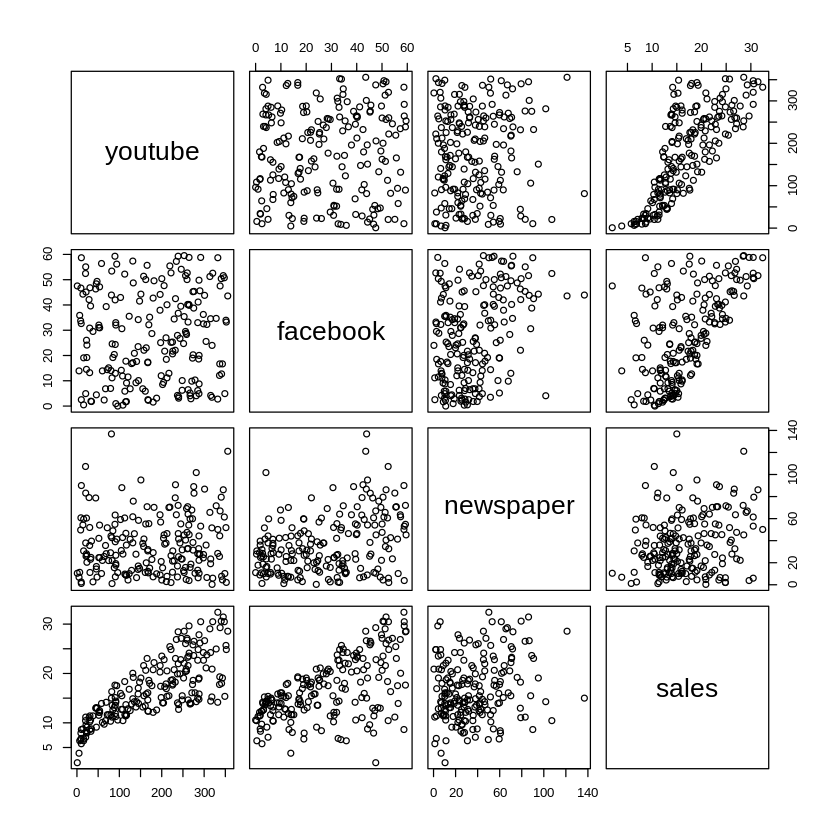

In [23]:
# (5) Code Here
pairs(marketing)

Here are some notes on the relationships:

- The relationship between `sales` and `youtube` appears nonlinear, with a sharp increase in sales for a small increase in YouTube advertising in the lower range of `youtube`. As more money is spent on YouTube advertising, however, the increase in sales is less prevalent.

- It's also worth noting that, as `youtube` increases, the variability in sales also increases.

- There appears to be a linear relationship between `sales` and `facebook`, too, but with a lot of variability, especially for high vales of `facebook` and low `sales`.

- There doesn't appear to be a relationship between `sales` and `newspaper`.

- There aren't any other strong trends in the data.

### Exercise 2 Linear regression modeling

First, let's randomly split the data into a "training set" and "testing set". We do this so that we can train/fit the linear model on the training set, and then, if necessary, see how well the model fits (e.g., does it make reasonable predictions?) in the testing set. In this lesson, we will only briefly look at fit metrics on the testing set; but, it's good practice to split the data in this (or a similar) way when wanting to assess the fit or predictive power of the model.

Write code to randomly select $80\%$ of the rows from the `marketing` dataframe. Store these rows in a dataframe `train`. Then, store the remaining rows in a dataframe called `test`.

In [54]:
# (6) Code Here
set.seed(11)
n = floor(0.8*nrow(marketing))

index = sample(seq_len(nrow(marketing)),size=n)

training = marketing[index,]
testing = marketing[-index,]

**The `lm()` function**

`R` has a great function for fitting and summarizing linear regression models: the `lm()` function. `lm()` will fit a linear regression model to data using least squares (or other methods, when specified), and provide many summary statistics. Let's look at some basics of `lm()`. As we progress through the course, we'll learn to work with more and more of the output of the `lm()` function.

The `lm()` function may take in several arguments, but only a small number of them are required. The first required argument is the `formula`: it should be in the following format: `response ~ predictor1 + predictor2 + ... + predictorP`. If your data are stored in a dataframe (which will often be the case), then the simplest thing to do is specify a second argument, namely `data = NameOfDataFrame`. Let's use `lm()` on the training subset of the marketing data, with just `facebook` as a predictor. **Be sure to use the training data (not the entire marketing data). Store your `lm()` object in the variable `lm_marketing`.**

After you've fit the model using `lm()`, clearly write out the fitted model and interpret the parameter estimates.

In [55]:
# (7) Code Here
lm_marketing = lm(sales ~ facebook, data = training)
lm_marketing

summary(lm_marketing)


Call:
lm(formula = sales ~ facebook, data = training)

Coefficients:
(Intercept)     facebook  
    11.3279       0.1929  



Call:
lm(formula = sales ~ facebook, data = training)

Residuals:
    Min      1Q  Median      3Q     Max 
-18.573  -2.535   1.069   3.422  10.160 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 11.32793    0.82030  13.810  < 2e-16 ***
facebook     0.19287    0.02396   8.049 1.88e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.387 on 158 degrees of freedom
Multiple R-squared:  0.2908,	Adjusted R-squared:  0.2863 
F-statistic: 64.79 on 1 and 158 DF,  p-value: 1.881e-13


The `summary()` function applied to an `lm()` object gives is plenty of output:

- First, the summary function reminds us of the formula for the model, i.e., that `sales` is the response and `facebook` the predictor.

- Next, we have summary statistics for the residuals of the model. Recall that the residuals are defined as $\varepsilon_i = y_i - \widehat{y_i}$, where $\widehat{y_i} = \widehat\beta_0 + \widehat\beta_1facebook_i, \,\, i = 1,...,n$ are the fitted values of the model. If the model fits well, the residuals will look *roughly* normal/random scatter around zero.

- Next, we see a table of, among other things, the least squares estimates for the model. In the last module, we learned how to interpret these estimates:
    - If the model is correct, then if a company spend zero dollars on Facebook advertising, they can expect to sell roughly $\widehat\beta_0 \times 1000 = 11.33 \times 1,000 = 11,330$ units, on average.
    
    - If the model is correct, then, for a $\$1,000$ increase in the Facebook advertising budget, the company can expect to sell roughly $\widehat\beta_1 \times 1000 = 0.19 \times 1,000 = 190$ more units, on average.
    

- We'll ignore the remaining components of the coefficient table for now, but will return to them soon!

- We'll also ignore the residual standard error, $R^2$, and F-statistic information. We'll return to this when we discuss regression inference.

**Visualizing the regression model**

We will learn a few important visualizations of the linear regression model in the modules to come. For now, let's just visualize our data with the regression model imposed on it.

Construct a scatter plot of `sales` ($y$) against `facebook` ($x$) *from the training data*, and plot the fitted line over the data. You can use "base R" functions like `plot()` and `abline()`, or be fancy and use `ggplot()`!

`geom_smooth()` using formula = 'y ~ x'


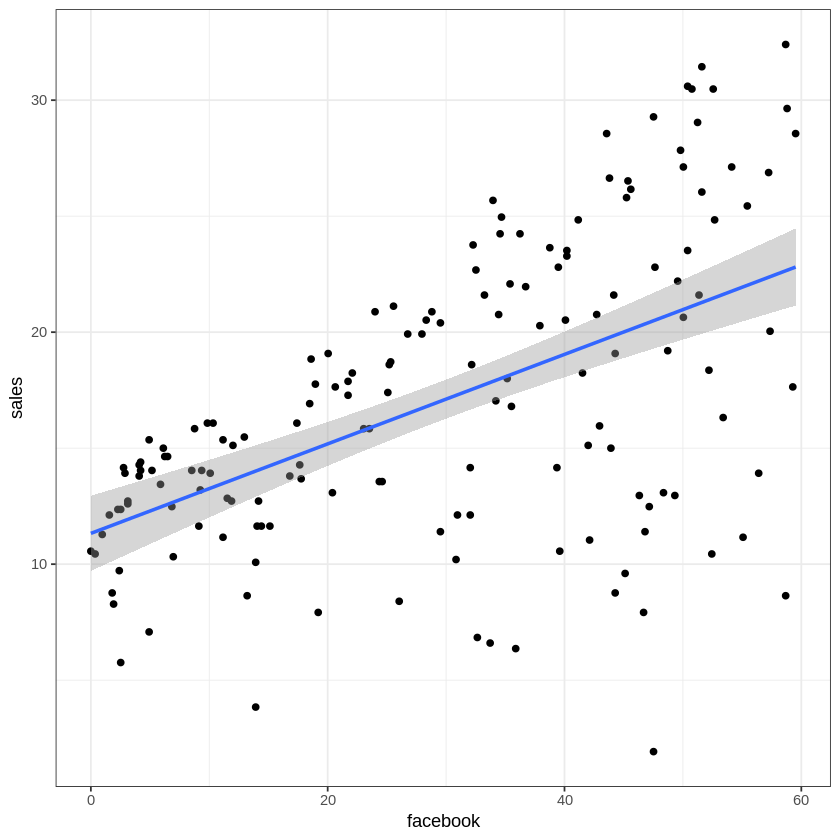

In [56]:
# (8) Code Here
ggplot(training,aes(x=facebook, y=sales))+
  geom_point()+
  geom_smooth(method = "lm")+
  theme_bw()

Note that the fit looks OK, but that there is a lot of variability in `sales`, especially for higher values of `facebook`. Imagine making a prediction for `sales` for `facebook = 60`:

In [57]:
# (9) Code Here
yhat_60 = coef(lm_marketing)[1] + coef(lm_marketing)[2] * 60
yhat_60

(Intercept) 
    22.9002

The model predicts `sales = 22.9`: that is, the model predicts that a company with a facebook marketing budget of $\$60,000$ will sell $22,900$ units of product $P$, on average. But look at other measurements near $\$60,000$; based on the data, sales could be as low as $9,000$ units or over $30,000$ units.

Finally, let's take a look at how the plot would look using the testing data instead of the training data. Ideally, we would want the the model to fit well for the testing data too.

Construct a scatter plot of `sales` ($y$) against `facebook` ($x$) *from the test data* and plot the fitted line over the data. You can use "base R" functions like `plot()` and `abline()`, or be fancy and use `ggplot()`!

Note that overlaying the regression line on a scatterplot of the data is not a rigorous way of assessing the fit of the model; later on in the course, we will learn better goodness of fit metrics for linear regression.

`geom_smooth()` using formula = 'y ~ x'


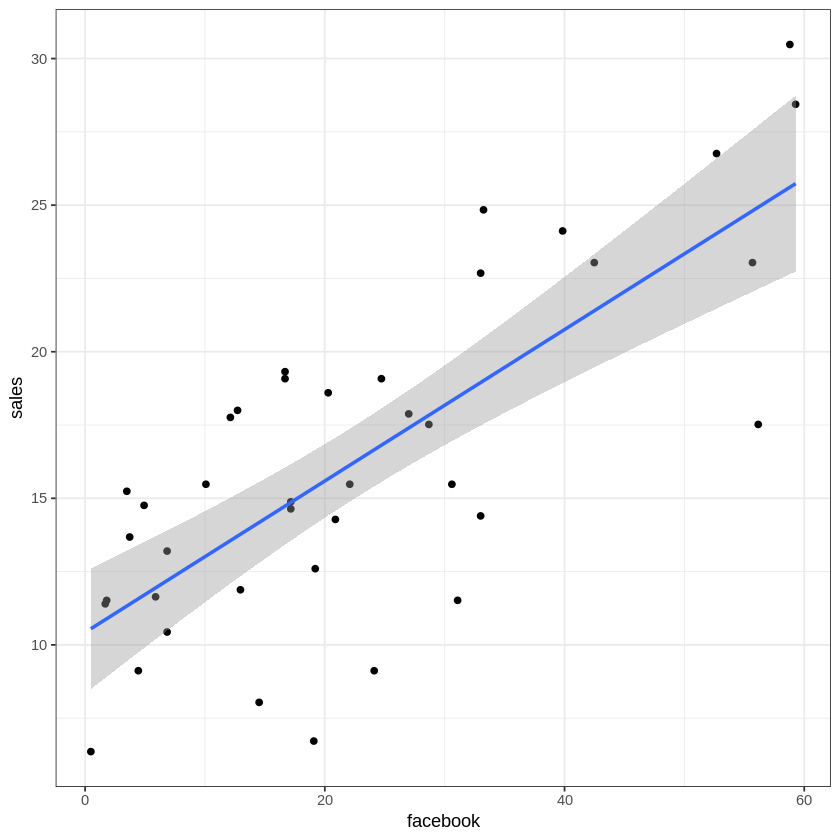

In [58]:
ggplot(testing,aes(x=facebook, y=sales))+
  geom_point()+
  geom_smooth(method = "lm")+
  theme_bw()